# 2 Self-Attention Layer in Transformer (40%)

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import re

from torch import nn
import torch.nn.functional as F
import math

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# 1. Read and Parse Data
train_data = pd.read_csv('/kaggle/input/llm-hw1-q2/train.csv')
val_data = pd.read_csv('/kaggle/input/llm-hw1-q2/val.csv')
test_data = pd.read_csv('/kaggle/input/llm-hw1-q2/test.csv')

X_train = train_data['text'].values
y_train = train_data['label'].values

X_val = val_data['text'].values
y_val = val_data['label'].values

X_test = test_data['text'].values
y_test = test_data['label'].values

In [4]:
# 2. Tokenize Data
def tokenizer(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text.split()

def build_vocab(sentences):
    counter = Counter()
    for sentence in sentences:
        tokens = tokenizer(sentence)
        counter.update(tokens)
    vocab = {word: idx+2 for idx, (word, _) in enumerate(counter.items())} 
    vocab["<pad>"] = 0
    vocab["<unk>"] = 1
    return vocab

vocab = build_vocab(X_train)

In [5]:
# 3. Preprocess Data
def text_pipeline(text, vocab):
    tokens = tokenizer(text)
    return [vocab.get(token, vocab["<unk>"]) for token in tokens]

label_vocab = {label: idx for idx, label in enumerate(set(y_train))}

def label_pipeline(label):
    label_index = label_vocab[label]
    one_hot = torch.zeros(4, dtype=torch.float)
    one_hot[label_index] = 1.0
    
    return one_hot

In [6]:
# 4. Prepare Data
X_train_seq = [torch.tensor(text_pipeline(text, vocab)) for text in X_train]
X_val_seq = [torch.tensor(text_pipeline(text, vocab)) for text in X_val]
X_test_seq = [torch.tensor(text_pipeline(text, vocab)) for text in X_test]

X_train_pad = pad_sequence(X_train_seq, batch_first=True, padding_value=vocab["<pad>"])
X_val_pad = pad_sequence(X_val_seq, batch_first=True, padding_value=vocab["<pad>"])
X_test_pad = pad_sequence(X_test_seq, batch_first=True, padding_value=vocab["<pad>"])

max_len = 32
X_train_pad = X_train_pad[:, :max_len]
X_val_pad = X_val_pad[:, :max_len]
X_test_pad = X_test_pad[:, :max_len]

X_train_pad = torch.cat([
    X_train_pad, 
    torch.full((X_train_pad.size(0), max_len - X_train_pad.size(1)), vocab["<pad>"])
], dim=1)

X_val_pad = torch.cat([
    X_val_pad, 
    torch.full((X_val_pad.size(0), max_len - X_val_pad.size(1)), vocab["<pad>"])
], dim=1)

X_test_pad = torch.cat([
    X_test_pad, 
    torch.full((X_test_pad.size(0), max_len - X_test_pad.size(1)), vocab["<pad>"])
], dim=1)

y_train_tensor = torch.stack([label_pipeline(label) for label in y_train])
y_val_tensor = torch.stack([label_pipeline(label) for label in y_val])
y_test_tensor = torch.stack([label_pipeline(label) for label in y_test])



In [7]:
# 5. Create DataLoader
train_dataset = TensorDataset(X_train_pad, y_train_tensor)
val_dataset = TensorDataset(X_val_pad, y_val_tensor)
test_dataset = TensorDataset(X_test_pad, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
# 6. PositionalEncoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

## 1. Please complete the code in the atten.ipynb file, which is an encoder for a text classification task. You only need to write the Multi-head Attention and Transformer Encoder layer, which correspond to the “TODO” section in the code. Do not use the class torch.nn.MultiheadAttention, and use the provided hyperparameters.

In [9]:
# 7. Multi-head Attention
class MyMultiheadAttention(nn.Module):
    # ----- TODO ----- #
    # Multi-head Attention Layer. Please study Transformer paper https://arxiv.org/pdf/1706.03762
    # ----- TODO ----- #
    def __init__(self, d_model, nhead, dropout, context_length):
        super(MyMultiheadAttention, self).__init__() # 用來呼叫MyMultiheadAttention
        assert d_model % nhead == 0   # 模型的維度一定要能被頭的數量整除
        
        self.d_model = d_model
        self.nhead = nhead
        self.head_dim = d_model // nhead #頭的維度為模型維度除以頭的數量

        self.W_q = nn.Linear(d_model, d_model) #Query matrix
        self.W_k = nn.Linear(d_model, d_model) #Key matrix
        self.W_v = nn.Linear(d_model, d_model) #Value matrix
        self.W_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        
        # 在decoder中需要mask來遮住一部份的tokens
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))
     
    def forward(self, x):
        b, num_tokens, _ = x.shape
        
        queries = self.W_q(x).view(b, num_tokens, self.nhead, self.head_dim).transpose(1, 2)
        keys = self.W_k(x).view(b, num_tokens, self.nhead, self.head_dim).transpose(1, 2) 
        values = self.W_v(x).view(b, num_tokens, self.nhead, self.head_dim).transpose(1, 2)

        # 計算attnetion weight
        attention_scores = queries @ keys.transpose(2, 3)  # Dot product for each head
        attention_weights = torch.softmax(attention_scores / keys.shape[-1]**0.5, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # 上三角矩陣，在decoder時用來遮住第i個位置後的token
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # 被遮住位置的attention score都會是0
        attention_scores.masked_fill_(mask_bool, -torch.inf)
        
        # Attention (Q,K,V)
        # Attnetion weight的維度為(b, nhead, num_tokens, num_tokens)
        # Values的維度為(b, num_tokens, nhead, head_dim)
        context_vec = (attention_weights @ values).transpose(1, 2) 
        
        # MultiHead(Q,K,V)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_model)
        context_vec = self.W_out(context_vec)

        return context_vec

In [35]:
# 8. TransformerEncoderLayer
class MyTransformerEncoderLayer(nn.Module):
    # ----- TODO ----- #
    # Transformer Encoder Layer. Please study Transformer paper https://arxiv.org/pdf/1706.03762
    # ----- TODO ----- #
    def __init__(self, d_model, nhead, dropout, dim_feedforward, context_length):
        super(MyTransformerEncoderLayer, self).__init__()
    
        # 引進在Multi-head attention的輸出
        self.self_attention = MyMultiheadAttention(d_model, nhead, dropout, context_length)
    
        # Feed forward
        self.feed_forward = nn.Sequential(
                nn.Linear(d_model, dim_feedforward),  # 第一層線性組合層
                nn.ReLU(),                           # ReLu
                nn.Linear(dim_feedforward, d_model)   # 第二層線性組合層
            )
    
        # Layer Normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x):
        # Multi-Head Self-Attention
        attention_output = self.self_attention(x)
        x = self.norm1(x + self.dropout1(attention_output))  # Residual connection + Norm
        
        # Feed-Forward Network
        ffn_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ffn_output))  # Residual connection + Norm
        
        return x
                                        

In [51]:
# 9. TransformerClassifier
class TransformerClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        output_dim,
        pad_idx,
        nhead=nhead,
        num_layers=6,
    ):
        super(TransformerClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=0.2,
            max_len=embedding_dim,  
        )
        
        self.encoder_layers = nn.ModuleList(
            [MyTransformerEncoderLayer(d_model=embedding_dim, nhead=nhead, dim_feedforward=64, dropout=0.2, context_length=128) 
             for _ in range(num_layers)]
        )

        self.linear_layer = nn.Linear(embedding_dim, 32)
        self.classifier = nn.Linear(32, output_dim)
        self.d_model = embedding_dim

    def forward(self, x):
        x = self.embedding(x) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float))  
        x = self.pos_encoder(x)
        
        for layer in self.encoder_layers:
            x = layer(x)

        x = x.mean(dim=1)
        
        x = self.linear_layer(x)
        x = torch.tanh(x)
        
        x = self.classifier(x)
        
        return x  

In [52]:
# 10. Define Hyperparameters
vocab_size = len(vocab)
embedding_dim = 128
output_dim = len(label_vocab)
pad_idx = vocab["<pad>"]

In [38]:
# 11. Create Model
model = TransformerClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    output_dim=output_dim,
    pad_idx=pad_idx,
    nhead=4,  
    num_layers=6 
)

In [39]:
print(model)

TransformerClassifier(
  (embedding): Embedding(9547, 128, padding_idx=0)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder_layers): ModuleList(
    (0-5): 6 x MyTransformerEncoderLayer(
      (self_attention): MyMultiheadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=True)
        (W_k): Linear(in_features=128, out_features=128, bias=True)
        (W_v): Linear(in_features=128, out_features=128, bias=True)
        (W_out): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (feed_forward): Sequential(
        (0): Linear(in_features=128, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.2, inplace=False)
      (drop

In [40]:
# 12. Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [41]:
# 13. Define Training and Evaluation Functions
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    results = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        model.train()

        batch_loss = []
        batch_acc = []
        
        for batch in train_loader:
            X_batch, y_batch = batch
            
            optimizer.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)

            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())

            _, predicted = torch.max(output, 1)
            y_indices = y_batch.argmax(dim=1)  
            correct = (predicted == y_indices).sum().item()
            batch_acc.append(correct / y_batch.size(0))
        
        results['train_loss'].append(np.mean(batch_loss))
        results['train_acc'].append(np.mean(batch_acc))

        model.eval()
        total_correct = 0  
        total_samples = 0  
        val_batch_loss = []  
        
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                val_output = model(X_val_batch)
                val_loss = criterion(val_output, y_val_batch)
                val_batch_loss.append(val_loss.item())
                
                _, predicted = torch.max(val_output, 1)
                y_val_indices = y_val_batch.argmax(dim=1)
                total_correct += (predicted == y_val_indices).sum().item()
                total_samples += y_val_batch.size(0)

        results['val_loss'].append(np.mean(val_batch_loss))
        results['val_acc'].append(total_correct / total_samples)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {results['train_loss'][-1]:.4f}, "
              f"Train Acc: {results['train_acc'][-1]:.4f}, Val Loss: {results['val_loss'][-1]:.4f}, "
              f"Val Acc: {results['val_acc'][-1]:.4f}")
        
    return results

In [42]:
# 14. Train Model
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100)

Epoch 1/100, Train Loss: 1.3721, Train Acc: 0.3028, Val Loss: 1.3154, Val Acc: 0.3669
Epoch 2/100, Train Loss: 1.2609, Train Acc: 0.4327, Val Loss: 1.2671, Val Acc: 0.4194
Epoch 3/100, Train Loss: 1.1332, Train Acc: 0.5296, Val Loss: 1.1867, Val Acc: 0.5000
Epoch 4/100, Train Loss: 1.0489, Train Acc: 0.5783, Val Loss: 1.1199, Val Acc: 0.5444
Epoch 5/100, Train Loss: 0.9450, Train Acc: 0.6354, Val Loss: 0.9624, Val Acc: 0.6210
Epoch 6/100, Train Loss: 0.8876, Train Acc: 0.6600, Val Loss: 0.9358, Val Acc: 0.6331
Epoch 7/100, Train Loss: 0.8095, Train Acc: 0.7033, Val Loss: 0.9255, Val Acc: 0.6935
Epoch 8/100, Train Loss: 0.7581, Train Acc: 0.7231, Val Loss: 0.9253, Val Acc: 0.6573
Epoch 9/100, Train Loss: 0.6876, Train Acc: 0.7480, Val Loss: 0.8269, Val Acc: 0.7097
Epoch 10/100, Train Loss: 0.6605, Train Acc: 0.7677, Val Loss: 0.8731, Val Acc: 0.6895
Epoch 11/100, Train Loss: 0.6042, Train Acc: 0.7816, Val Loss: 0.8077, Val Acc: 0.7258
Epoch 12/100, Train Loss: 0.5816, Train Acc: 0.7915,

### (a) Please set the number of attention heads to 4 and plot the learning curves (training loss) and the accuracy rate curves of training and validation data during training.(20%)


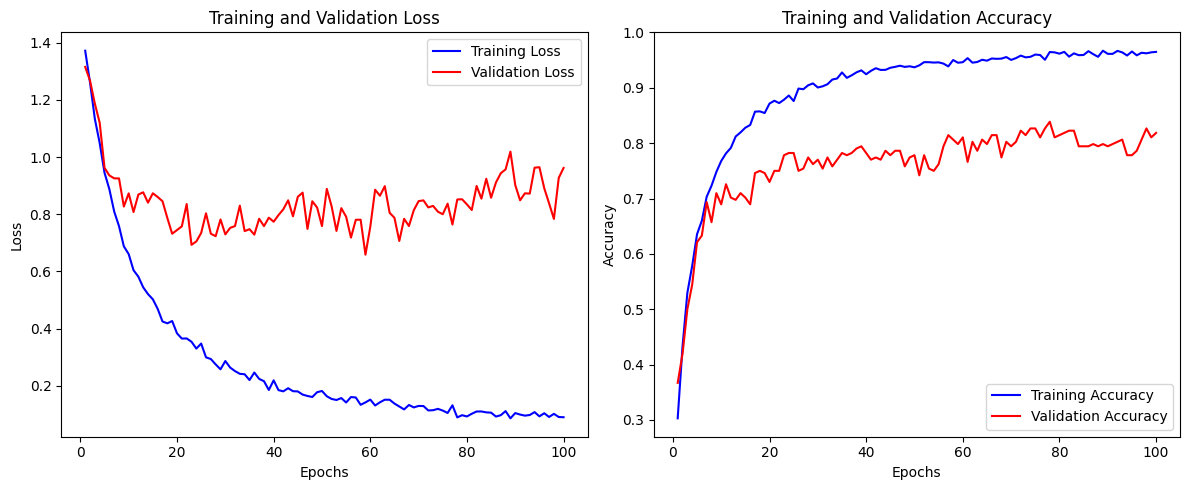

In [43]:
# 15. Plot result
import matplotlib.pyplot as plt

epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

當模型head數固定在4的時候，可以看到訓練損失不斷下降，而驗證的損失則是在0.7到1左右之間震盪。準確率的的話，訓練資料的準確率可以達到96%，驗證集的資料到了訓練時期快結束時，大概都落在78~80%左右。

### (b) Use test.csv as input to your model and calculate the test accuracy. (10%)

In [44]:
# 16. Evaluate Model

def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    total_correct = 0
    total_samples = 0
    test_batch_loss = []

    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            test_output = model(X_test_batch)
            test_loss = criterion(test_output, y_test_batch)
            test_batch_loss.append(test_loss.item())

            _, predicted = torch.max(test_output, 1)
            y_test_indices = y_test_batch.argmax(dim=1)
            total_correct += (predicted == y_test_indices).sum().item()
            total_samples += y_test_batch.size(0)

    test_loss = np.mean(test_batch_loss)
    test_acc = total_correct / total_samples
    return test_loss, test_acc

test_loss, test_acc = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 0.9080, Test Acc: 0.7972


當head的數量設定為4時，以測試資料計算出來的準確率為0.7972。

### (c) Reduce the number of attention heads (down to 1) and increase it (up to 8). Compare the results and provide some discussion. (10%)

In [62]:
# 9. TransformerClassifier
class TransformerClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        output_dim,
        pad_idx,
        nhead=nhead,
        num_layers=6,
    ):
        super(TransformerClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=0.2,
            max_len=embedding_dim,  
        )
        
        self.encoder_layers = nn.ModuleList(
            [MyTransformerEncoderLayer(d_model=embedding_dim, nhead=nhead, dim_feedforward=64, dropout=0.2, context_length=128) 
             for _ in range(num_layers)]
        )

        self.linear_layer = nn.Linear(embedding_dim, 32)
        self.classifier = nn.Linear(32, output_dim)
        self.d_model = embedding_dim

    def forward(self, x):
        x = self.embedding(x) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float))  
        x = self.pos_encoder(x)
        
        for layer in self.encoder_layers:
            x = layer(x)

        x = x.mean(dim=1)
        
        x = self.linear_layer(x)
        x = torch.tanh(x)
        
        x = self.classifier(x)
        
        return x  

In [63]:
# 10. Define Hyperparameters
vocab_size = len(vocab)
embedding_dim = 128
output_dim = len(label_vocab)
pad_idx = vocab["<pad>"]

在這裡執行兩次以下的程式碼， 分別為nhead=1與nhead=8：

In [57]:
# 11. Create Model (n=1)
model = TransformerClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    output_dim=output_dim,
    pad_idx=pad_idx,
    nhead=1,  
    num_layers=6 
)

In [58]:
# 12. Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [59]:
# 13. Define Training and Evaluation Functions
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    results = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    for epoch in range(epochs):
        model.train()

        batch_loss = []
        batch_acc = []
        
        for batch in train_loader:
            X_batch, y_batch = batch
            
            optimizer.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)

            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())

            _, predicted = torch.max(output, 1)
            y_indices = y_batch.argmax(dim=1)  
            correct = (predicted == y_indices).sum().item()
            batch_acc.append(correct / y_batch.size(0))
        
        results['train_loss'].append(np.mean(batch_loss))
        results['train_acc'].append(np.mean(batch_acc))

        model.eval()
        total_correct = 0  
        total_samples = 0  
        val_batch_loss = []  
        
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                val_output = model(X_val_batch)
                val_loss = criterion(val_output, y_val_batch)
                val_batch_loss.append(val_loss.item())
                
                _, predicted = torch.max(val_output, 1)
                y_val_indices = y_val_batch.argmax(dim=1)
                total_correct += (predicted == y_val_indices).sum().item()
                total_samples += y_val_batch.size(0)

        results['val_loss'].append(np.mean(val_batch_loss))
        results['val_acc'].append(total_correct / total_samples)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {results['train_loss'][-1]:.4f}, "
              f"Train Acc: {results['train_acc'][-1]:.4f}, Val Loss: {results['val_loss'][-1]:.4f}, "
              f"Val Acc: {results['val_acc'][-1]:.4f}")
        
    return results

In [60]:
# 14. Train Model
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100)

Epoch 1/100, Train Loss: 1.3839, Train Acc: 0.2915, Val Loss: 1.3463, Val Acc: 0.3306
Epoch 2/100, Train Loss: 1.3084, Train Acc: 0.3771, Val Loss: 1.3485, Val Acc: 0.3508
Epoch 3/100, Train Loss: 1.2585, Train Acc: 0.4403, Val Loss: 1.3472, Val Acc: 0.3508
Epoch 4/100, Train Loss: 1.1845, Train Acc: 0.4932, Val Loss: 1.2273, Val Acc: 0.4395
Epoch 5/100, Train Loss: 1.1078, Train Acc: 0.5331, Val Loss: 1.3372, Val Acc: 0.4597
Epoch 6/100, Train Loss: 1.0524, Train Acc: 0.5724, Val Loss: 1.2421, Val Acc: 0.4758
Epoch 7/100, Train Loss: 0.9886, Train Acc: 0.5913, Val Loss: 1.1273, Val Acc: 0.5323
Epoch 8/100, Train Loss: 0.9825, Train Acc: 0.5927, Val Loss: 1.1741, Val Acc: 0.5363
Epoch 9/100, Train Loss: 0.9330, Train Acc: 0.6314, Val Loss: 1.0949, Val Acc: 0.5484
Epoch 10/100, Train Loss: 0.8615, Train Acc: 0.6634, Val Loss: 1.0352, Val Acc: 0.5605
Epoch 11/100, Train Loss: 0.8608, Train Acc: 0.6755, Val Loss: 1.1281, Val Acc: 0.5565
Epoch 12/100, Train Loss: 0.8012, Train Acc: 0.6856,

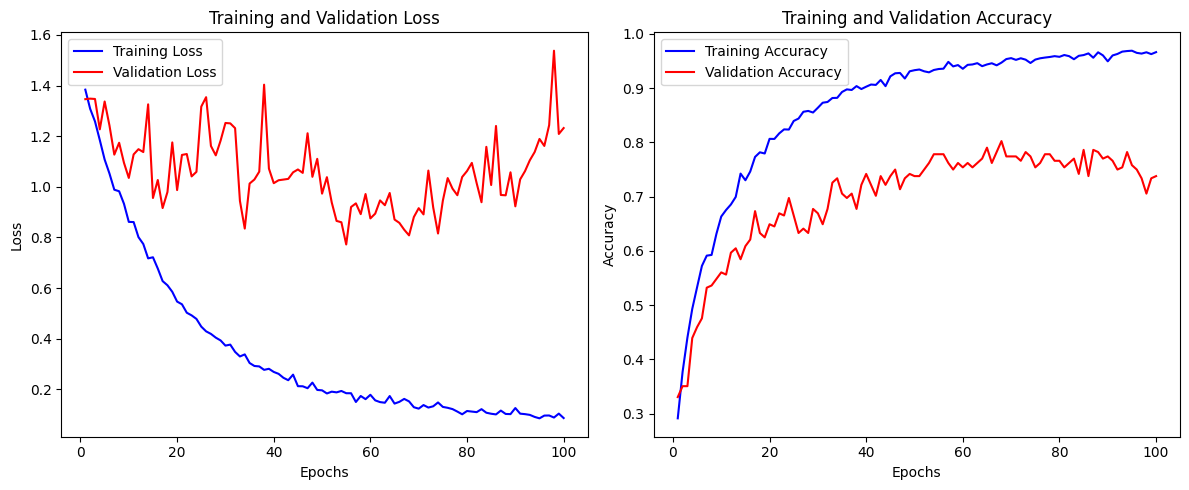

In [61]:
# 15. Plot result
import matplotlib.pyplot as plt

epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

再來是nhead=8的部分：

In [64]:
# 11. Create Model (n=8)
model = TransformerClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    output_dim=output_dim,
    pad_idx=pad_idx,
    nhead=8,  
    num_layers=6 
)

In [65]:
# 12. Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [66]:
# 13. Define Training and Evaluation Functions
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    results = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    for epoch in range(epochs):
        model.train()

        batch_loss = []
        batch_acc = []
        
        for batch in train_loader:
            X_batch, y_batch = batch
            
            optimizer.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)

            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())

            _, predicted = torch.max(output, 1)
            y_indices = y_batch.argmax(dim=1)  
            correct = (predicted == y_indices).sum().item()
            batch_acc.append(correct / y_batch.size(0))
        
        results['train_loss'].append(np.mean(batch_loss))
        results['train_acc'].append(np.mean(batch_acc))

        model.eval()
        total_correct = 0  
        total_samples = 0  
        val_batch_loss = []  
        
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                val_output = model(X_val_batch)
                val_loss = criterion(val_output, y_val_batch)
                val_batch_loss.append(val_loss.item())
                
                _, predicted = torch.max(val_output, 1)
                y_val_indices = y_val_batch.argmax(dim=1)
                total_correct += (predicted == y_val_indices).sum().item()
                total_samples += y_val_batch.size(0)

        results['val_loss'].append(np.mean(val_batch_loss))
        results['val_acc'].append(total_correct / total_samples)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {results['train_loss'][-1]:.4f}, "
              f"Train Acc: {results['train_acc'][-1]:.4f}, Val Loss: {results['val_loss'][-1]:.4f}, "
              f"Val Acc: {results['val_acc'][-1]:.4f}")
        
    return results

In [67]:
# 14. Train Model
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100)

Epoch 1/100, Train Loss: 1.3642, Train Acc: 0.3212, Val Loss: 1.3287, Val Acc: 0.3669
Epoch 2/100, Train Loss: 1.2067, Train Acc: 0.4676, Val Loss: 1.2014, Val Acc: 0.4677
Epoch 3/100, Train Loss: 1.0883, Train Acc: 0.5575, Val Loss: 1.1297, Val Acc: 0.5363
Epoch 4/100, Train Loss: 0.9772, Train Acc: 0.6115, Val Loss: 1.0386, Val Acc: 0.5444
Epoch 5/100, Train Loss: 0.8672, Train Acc: 0.6726, Val Loss: 0.9884, Val Acc: 0.6169
Epoch 6/100, Train Loss: 0.7837, Train Acc: 0.7095, Val Loss: 0.9625, Val Acc: 0.6371
Epoch 7/100, Train Loss: 0.6889, Train Acc: 0.7413, Val Loss: 0.9002, Val Acc: 0.6653
Epoch 8/100, Train Loss: 0.6382, Train Acc: 0.7645, Val Loss: 0.8369, Val Acc: 0.6976
Epoch 9/100, Train Loss: 0.5971, Train Acc: 0.7907, Val Loss: 0.8658, Val Acc: 0.7177
Epoch 10/100, Train Loss: 0.5418, Train Acc: 0.8018, Val Loss: 0.8076, Val Acc: 0.6976
Epoch 11/100, Train Loss: 0.5040, Train Acc: 0.8245, Val Loss: 0.7653, Val Acc: 0.7339
Epoch 12/100, Train Loss: 0.4583, Train Acc: 0.8349,

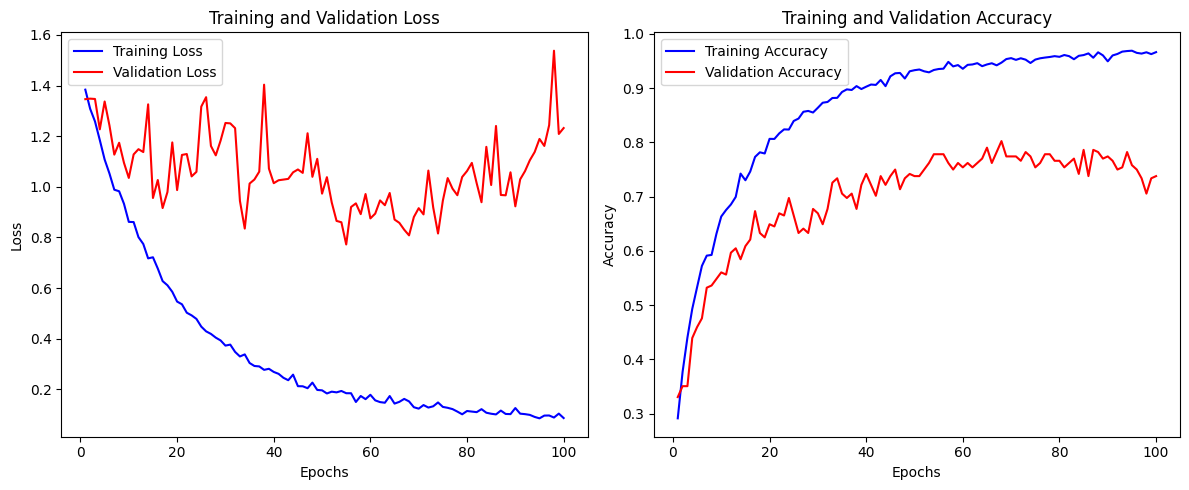

In [61]:
# 15. Plot result
import matplotlib.pyplot as plt

epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

執行完後比較結果，先從損失開始，當頭的數量(nhead)只有1的時候，訓練資料的損失最多只能降到0.08左右，但是在頭的數量為8時，訓練資料損失可以降到0.05左右；至於驗證資料的損失，兩者的表現看起來差不多，都會落在0.8到1.4之間。再來是準確率，當頭的數量為1的時候，訓練資料的準確率雖然也會達到90%以上，但是就需要執行比較多epoch，但頭的數量增加為8時，就不需要這麼多epoch就可以來到90%；驗證資料也有相同的現象，要執行30個epoch左右，準確率才會來到70%，但是頭的數量增加的時候，要達到同樣水準的驗證資料準確率，只要10個epoch左右就好了；整體的準確率上，頭的數量只有1時，驗證資料的準確率沒有辦法超過80%，但是頭的數量為8時，驗證資料的準確率是可以超過80%的。在硬體方面，當頭的數量為1時，訓練時間比較短，但是頭的數量為8時，參數量增加，對於CPU的使用量就會上升，如果資料量再增加，有可能會耗掉太多運算資源，兩者權衡之下，或許頭的數量可以取2或是4，就可以在運算資源與準確率上取得一個平衡。